In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [68]:
file_path = './../../Fed1_dataset/Interest_rate_prediction.csv'

# FED_ir의 의미 : FED interest rate
df_irp = pd.read_csv(file_path)

df_irp.head()

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2008-12-01,0.25,0.0,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of Minnea...,0.080,0.839,0.082,0.9133,2008-12
1,2009-01-01,0.25,0.0,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-02-01,0.25,0.0,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-02
3,2009-03-01,0.25,0.0,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,1.50,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-03
4,2009-04-01,0.25,0.0,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04


전처리

In [71]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE']) # 날짤형으로 변환

In [73]:
df_irp.dtypes

DATE            datetime64[ns]
DFEDTARU               float64
DFEDTARL               float64
IR_FORCAST             float64
GDPGR                  float64
UNRATE                 float64
PCEPI                  float64
TNX                    float64
USD                    float64
KR_IR                  float64
ECB_IR                 float64
BB_text                 object
BB_neg                 float64
BB_neu                 float64
BB_pos                 float64
BB_sentiment           float64
DATE_YM                 object
dtype: object

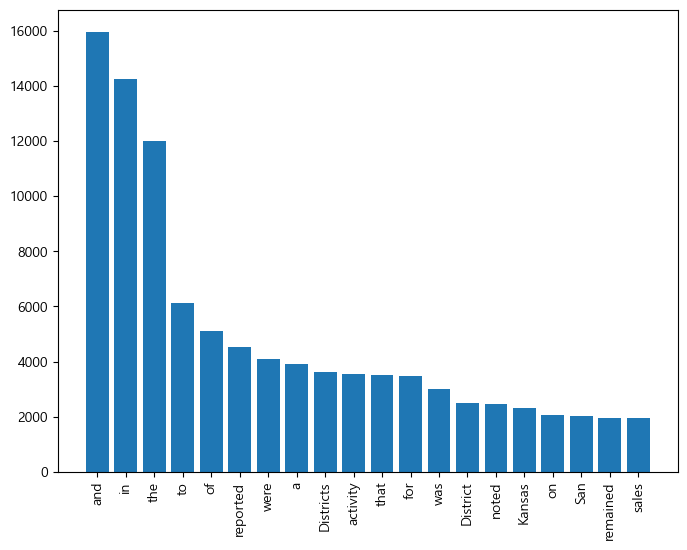

In [75]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [77]:
df_irp['BB_text'] = df_irp['BB_text'].str.lower()  # 소문자로
df_irp['BB_text'] = df_irp['BB_text'].str.strip()  # 앞뒤 공백 제거
df_irp['BB_text'] = df_irp['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
# 숫자, 대문자, 소문자 알파벳 및 공백을 제외한 모든 문자 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [79]:
# 불용어 제거
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_irp['BB_text'] = df_irp['BB_text'].apply(remove_stopwords)

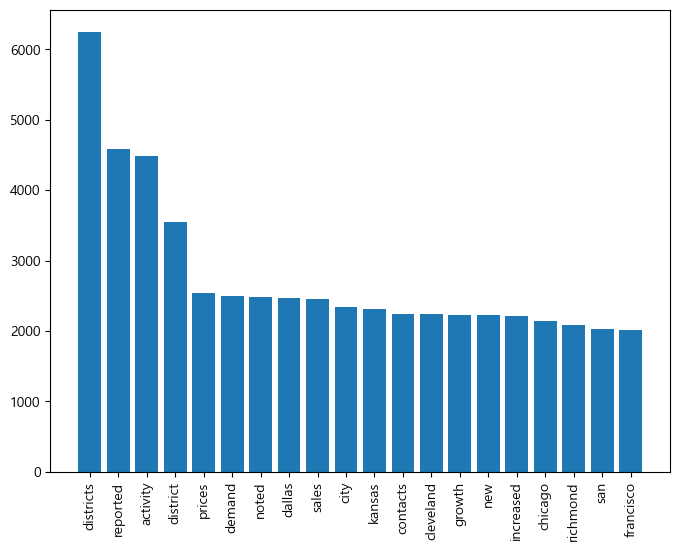

In [81]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

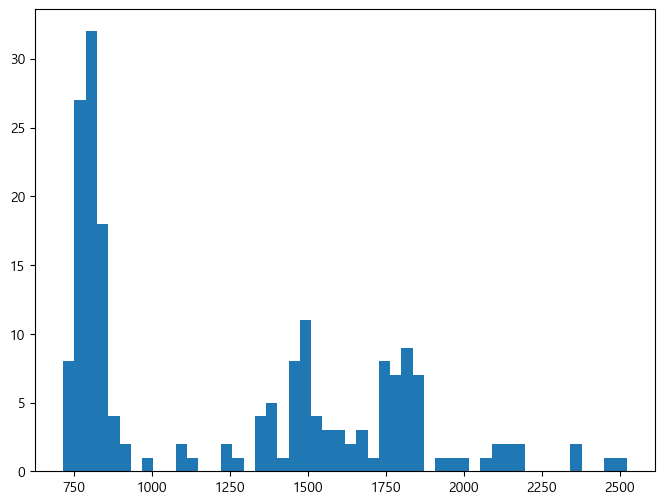

In [82]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

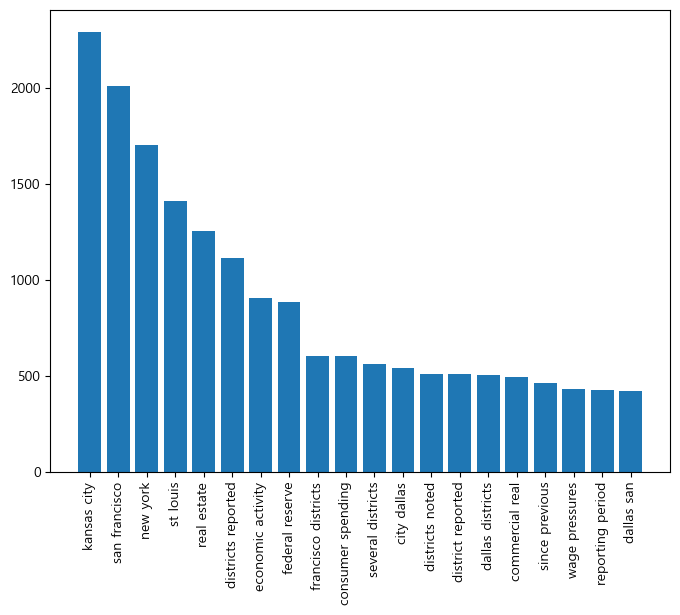

In [84]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

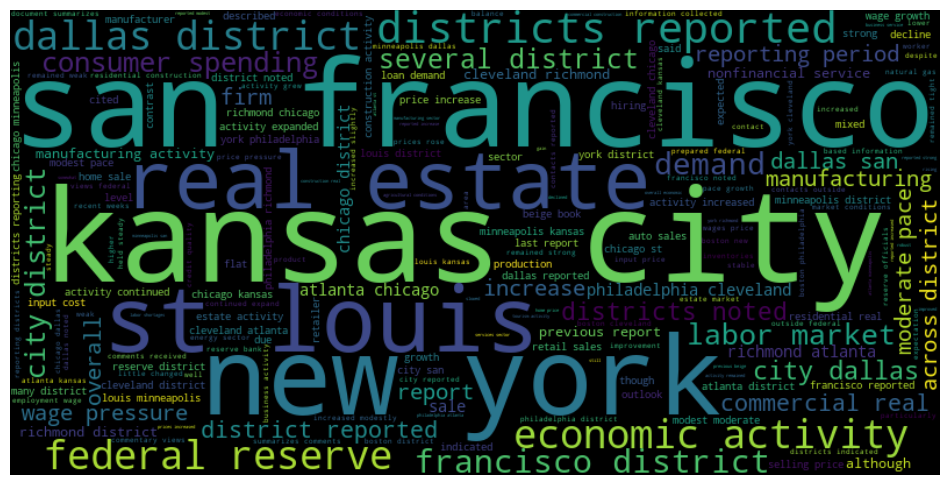

In [86]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [87]:
# 연방준비은행 지역 목록 제거st louis와 같은 경우도 감안
federal_reserve_banks = [
    "boston", 
    "new york", 
    "philadelphia", 
    "cleveland", 
    "richmond", 
    "atlanta", 
    "chicago", 
    "st. louis", 
    "minneapolis", 
    "kansas city", 
    "dallas", 
    "san francisco",
    "st",
    "louis"
]

# 연방준비은행 지역 필터링 함수
def remove_federal_reserve_banks(text, bank_list):
    # 소문자 변환 및 정규표현식을 사용하여 지역 이름 제거
    for bank in bank_list:
        bank_pattern = re.compile(re.escape(bank), re.IGNORECASE)
        text = bank_pattern.sub('', text)
    return text

# 연방준비은행 지역 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: remove_federal_reserve_banks(x, federal_reserve_banks))

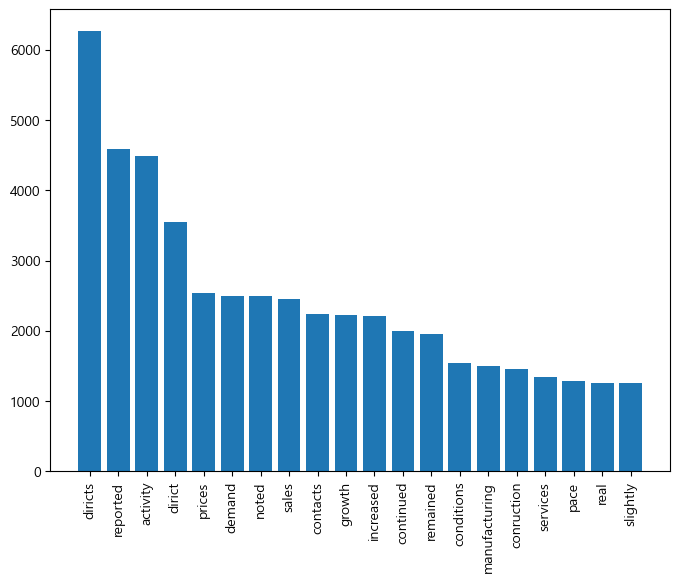

In [89]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

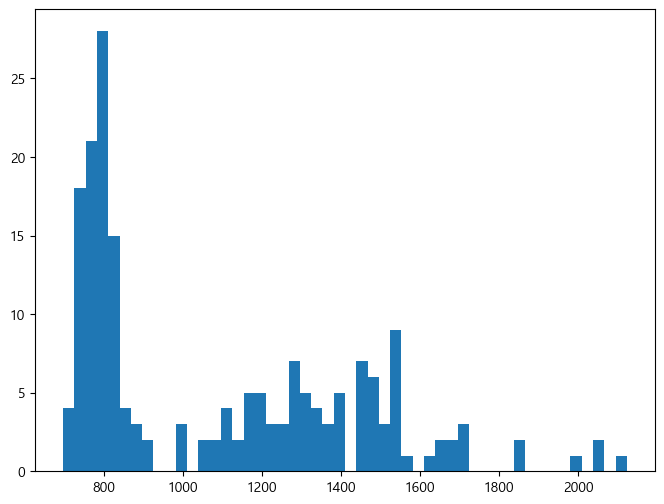

In [90]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

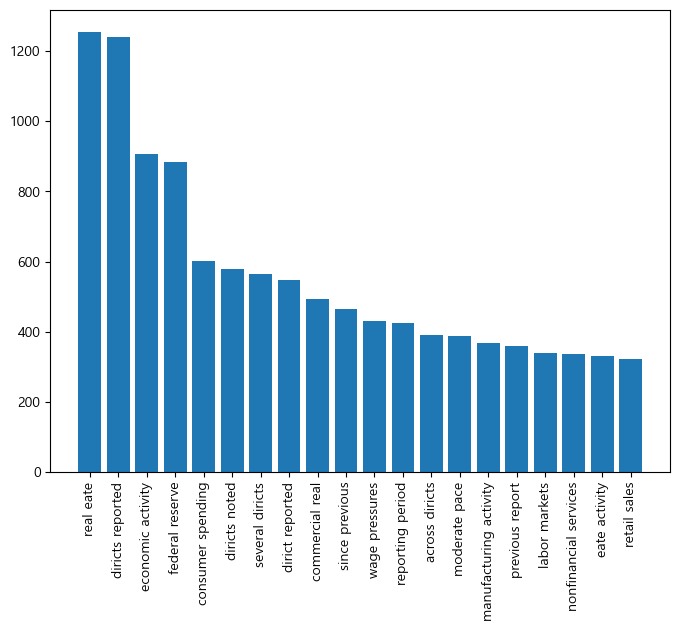

In [91]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

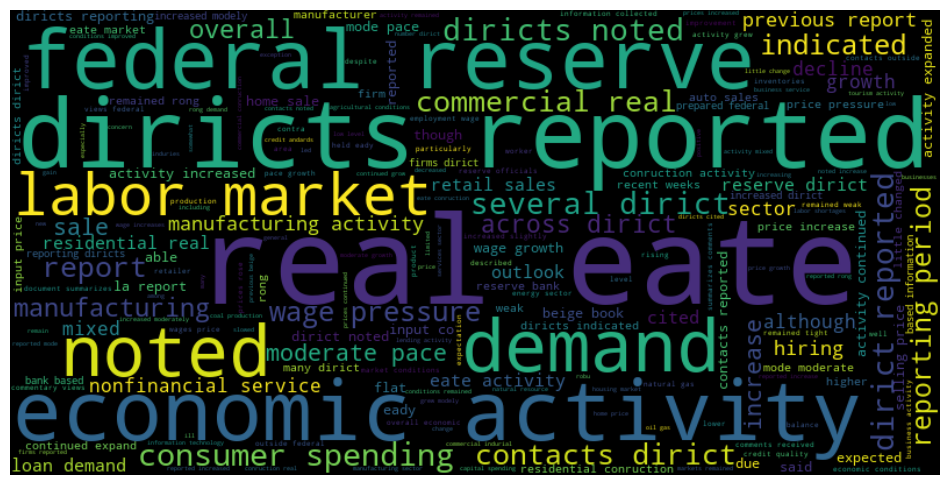

In [92]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

감정분석 : 전처리 이전과 이후 비교

In [94]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [95]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df_irp[['f_neg', 'f_neu', 'f_pos', 'f_sentiment']] = df_irp['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

df_irp

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,...,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM,text_length,f_neg,f_neu,f_pos,f_sentiment
0,2008-12-01,0.25,0.00,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,...,0.080,0.839,0.082,0.9133,2008-12,916,0.111,0.804,0.085,-0.9594
1,2009-01-01,0.25,0.00,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,...,0.061,0.865,0.074,0.9952,2009-01,1451,0.109,0.787,0.103,-0.6317
2,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,...,0.061,0.865,0.074,0.9952,2009-02,1451,0.109,0.787,0.103,-0.6317
3,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,...,0.083,0.839,0.078,0.5459,2009-03,1376,0.116,0.786,0.098,-0.8791
4,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,...,0.092,0.826,0.082,-0.6999,2009-04,1295,0.124,0.779,0.097,-0.9705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.206,1347.2,3.5,...,0.056,0.797,0.147,0.9991,2024-03,824,0.067,0.793,0.141,0.9966
184,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.109,4.686,1382.0,3.5,...,0.068,0.807,0.126,0.9974,2024-04,790,0.071,0.813,0.117,0.9886
185,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.146,4.514,1384.5,3.5,...,0.076,0.783,0.141,0.9982,2024-05,817,0.072,0.794,0.135,0.9953
186,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.243,4.343,1376.7,3.5,...,0.076,0.783,0.141,0.9982,2024-06,817,0.072,0.794,0.135,0.9953


LSTM

In [98]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [100]:
df_irp_new = df_irp[['DATE', 'DFEDTARU', 'GDPGR']]
df_irp_new = df_irp_new.astype({'DATE': 'datetime64[ns]'})

df_irp_new.sort_values('DATE', ascending=True, inplace=True)
df_irp_new

,DATE,DFEDTARU,GDPGR
0,2008-12-01,0.25,-8.5
1,2009-01-01,0.25,-4.5
2,2009-02-01,0.25,-4.5
3,2009-03-01,0.25,-4.5
4,2009-04-01,0.25,-0.7
...,...,...,...
183,2024-03-01,5.50,1.4
184,2024-04-01,5.50,2.8
185,2024-05-01,5.50,2.8
186,2024-06-01,5.50,2.8


In [102]:
# 과거 데이터를 통해 미래데이터를 예측하기 때문에 MinMaxScaler 사용
scaler = MinMaxScaler()
df_irp_new['GDPGR'] = scaler.fit_transform(df_irp_new[['GDPGR']])
df_irp_new['DFEDTARU'] = scaler.fit_transform(df_irp_new[['DFEDTARU']])

data = df_irp_new[['GDPGR', 'DFEDTARU']].values

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 1])
    return np.array(X), np.array(y)

In [104]:
sequence_length = 10 # 과거 10개 데이터 사용
X,y = create_sequences(data, sequence_length)
X.shape

(178, 10)

In [106]:
y.shape

(178,)

In [107]:
X = X.reshape((X.shape[0], X.shape[1], 1)) # 3차원으로 변환

In [108]:
#학습용, 검증용, 시험용으로 분리 7:1.5:1.5(8:1:1)보다 예측력이 높음
# train_size = int(len(X) * 0.8)
# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size+17], y[train_size:train_size+17]
# X_test, y_test = X[train_size+17:], y[train_size+17:]
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+17], y[train_size:train_size+17]
X_test, y_test = X[train_size+17:], y[train_size+17:]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics='acc')
# 검증 정확도 2번 개선 없으면 stop
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,callbacks=[early_stop])

Epoch 1/100
4/4 [==============================] - 2s 143ms/step - loss: 0.0256 - acc: 0.5984 - val_loss: 0.0178 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0226 - acc: 0.5984 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0221 - acc: 0.5984 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0213 - acc: 0.5984 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0201 - acc: 0.5984 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0208 - acc: 0.5984 - val_loss: 0.0114 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0207 - acc: 0.5984 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0205 - acc: 0.5

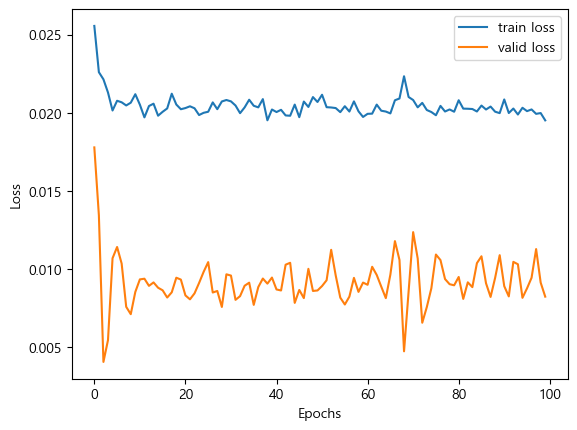

In [109]:
# 손실 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 341ms/step


In [113]:
# 역변환 후 실제 예측값 출력
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

#print('예측값 :',y_pred_rescaled)
#print('실제값 :',y_test_rescaled)

In [114]:
# 2024년 8월부터 12월까지 예측
future_dates = pd.date_range(start='2024-08-01', end='2024-12-01', freq='MS')
future_predictions = []

last_sequence = X[-1]  # 가장 최근의 시퀀스 가져오기

for _ in range(len(future_dates)):
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_pred[0, 0])
    # 새롭게 예측된 값을 시퀀스에 추가하고 첫 번째 값 제거
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# 예측값 역정규화
future_predictions_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, 1]

1/1 [==============================] - 0s 11ms/step


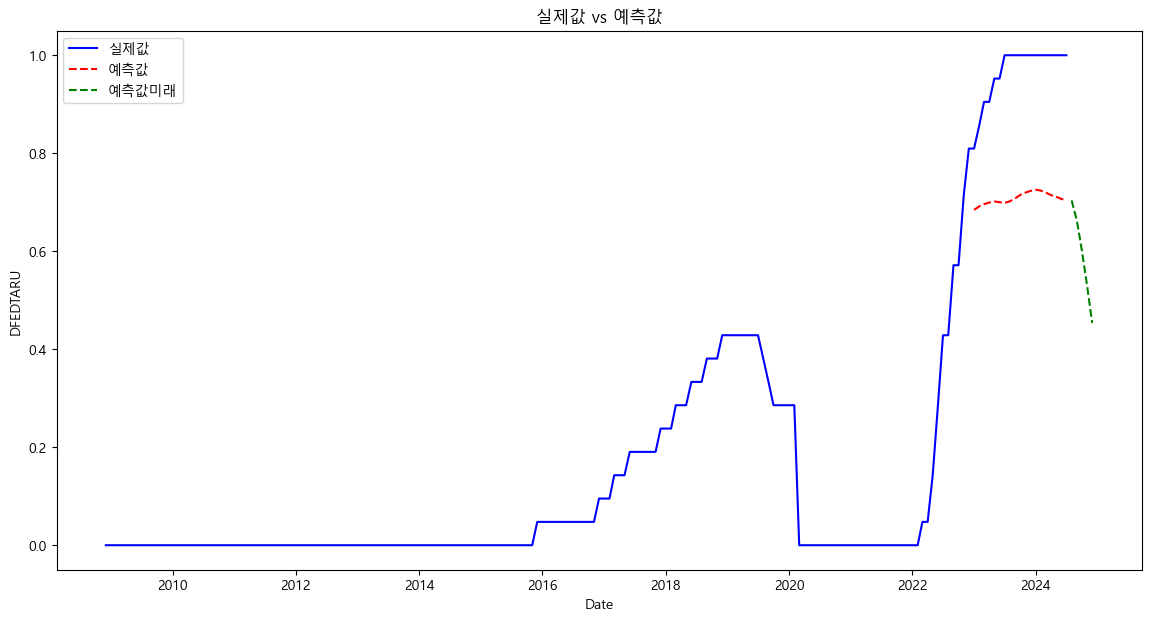

In [115]:
# 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_irp_new['DATE'], df_irp_new['DFEDTARU'], color='blue', label='실제값')
#plt.plot(df_irp_new['DATE'][-len(y_test_rescaled):], y_test_rescaled, color='blue', label='실제값')
plt.plot(df_irp_new['DATE'][-len(y_pred_rescaled):], y_pred_rescaled, color='red', linestyle='dashed', label='예측값')
plt.plot(future_dates, future_predictions_rescaled, color='green', linestyle='dashed', label='예측값미래')
plt.xlabel('Date')
plt.ylabel('DFEDTARU')
plt.title('실제값 vs 예측값')
plt.legend()
plt.show()

In [116]:
# 예측된 미래 데이터프레임 생성
future_df = pd.DataFrame({
    '모델명':['LSTM'],
    '실제값': [5.25],
    '예측값': [round(future_predictions[0], 5)],
    '차이': [round(5.25 - future_predictions[0], 5)] 
})

# 기존 파일에서 데이터 읽어오기 (파일이 존재하지 않는 경우 예외 처리)
try:
    existing_df = pd.read_csv('./result_Dong_model_202408.csv')
    combined_df = pd.concat([existing_df, future_df], ignore_index=True)
except FileNotFoundError:
    combined_df = future_df

# 결과를 CSV 파일로 저장
combined_df.to_csv('./result_Dong_model_202408.csv', index=False,encoding='utf-8-sig')